# $\textbf{Value function approximation}$ 

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from numba import njit

import Value_fun_NI as res0
import I0_no_func as res1
import Operator_I1 as res2
import parameters as params

import torch

import matplotlib.gridspec as gridspec

## Parameters

In [6]:
# Time span for integration#parameters

T = params.T  # Total simulation time
d = params.d  # Number of states
psi = params.psi  # Transition rate matrix
n_intgr = params.n_intgr  # Number of intervals for numerical integration
n= params.n 

t_span = params.t_span

λ_init, α, β, η, xi = params.λ_init, params.α, params.β, params.η, params.xi

pi0 = params.pi0 
kappa = params.kappa

beta = β
lambda_infty = params.lambda_infty

rho = params.rho
m1 = params.m1
c = params.c
e = params.e
eta = params.eta
c_prime = params.c_prime
c0 = params.c0
nu_0 = params.nu_0
t_span = (0, 10)  # Integration time from 0 to 10

fig = plt.figure(figsize=(9,9))

<Figure size 900x900 with 0 Axes>

## Weight

In [7]:
N = 1

In [8]:
model_name_prev = 'i{}net_model_sigmoid_switch_fourth_train.pth'.format(N-1)#fourth is the best

In [9]:
model_name = 'i{}net_model_sigmoid_switch_fourth_train.pth'.format(N)

In [10]:
path_name = model_name
# Instantiate the model
model_prev = res1.I1_func_Net()  
model_prev.load_state_dict(torch.load(model_name))
model = res1.I1_func_Net()  
model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [13]:
# Example usage
t = 0 
x = 5
s = 0
d = 0
kappa = np.array([3,5])
kappa_0 = np.array([[kappa[0], kappa[1]], [kappa[1], kappa[0]]])

mu = 0.0
mu_0 = np.array([mu,1-mu])
y_0 = (x, d, kappa_0, mu_0)

In [24]:
import torch

# Load the state_dict
def model_weights(file_path = model_name):
    state_dict = torch.load(file_path, map_location=torch.device('cpu'))

    # Extract the weights and biases and convert them to lists
    weights_1 = state_dict['fc1.weight'].cpu().tolist()
    biases_1 = state_dict['fc1.bias'].cpu().tolist()
    weights_2 = state_dict['fc2.weight'].cpu().tolist()
    biases_2 = state_dict['fc2.bias'].cpu().tolist()
    weights_3 = state_dict['fc3.weight'].cpu().tolist()
    biases_3 = state_dict['fc3.bias'].cpu().tolist()
    weights_4 = state_dict['fc4.weight'].cpu().tolist()
    biases_4 = state_dict['fc4.bias'].cpu().tolist()

    return np.array(weights_1), np.array(biases_1), np.array(weights_2), np.array(biases_2), np.array(weights_3), np.array(biases_3), np.array(weights_4), np.array(biases_4)

weights_1, biases_1, weights_2, biases_2, weights_3, biases_3, weights_4, biases_4 = model_weights(model_name)

In [25]:
# Define the sigmoid activation function
@njit
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Numba-compatible forward pass for I1_func_Net
@njit
def neural_net_forward_I1(t, u, y, weights):
    weights_1, biases_1, weights_2, biases_2, weights_3, biases_3, weights_4, biases_4 = weights
    x, d, kappa, mu = y
    kappa_flat = kappa.flatten()
    mu_flat = mu.flatten()
    
    # Creating the input vector
    inputs = np.array([t] + [u] + [x] + [d] + list(kappa_flat) + list(mu_flat), dtype=np.float64)
    
    # First layer
    x0 = np.dot(weights_1, inputs) + biases_1
    x0 = sigmoid(x0)
    
    # Second layer
    x0 = np.dot(weights_2, x0) + biases_2
    x0 = sigmoid(x0)
    
    # Third layer
    x0 = np.dot(weights_3, x0) + biases_3
    x0 = sigmoid(x0)
    
    # Output layer
    output = np.dot(weights_4, x0) + biases_4
    return output[0]

if weights_1.shape[1] != 7:
    raise ValueError("weights_1_I1 should have 7 columns for the given inputs.")

y = (y_0[0], y_0[1], y_0[2][0], np.array(y_0[3][0]))


Output I1: 12.300378802341434


In [ ]:
weights = model_weights(model_name)

In [ ]:
#grid_points_all = np.linspace(0, T, 20)
@njit
def W1(t, y_0, weights):
    y = (y_0[0], y_0[1], y_0[2][0], np.array(y_0[3][0]))
    # Generate grid points
    # Use np.searchsorted to find the index of the first element >= t
    grid_points_all = np.linspace(0, T, 20)
    idx = np.searchsorted(grid_points_all, t)

    # Get the optimized result
    grid_points = grid_points_all[idx:]

    # Evaluate the function at grid points
    values = np.array([neural_net_forward_I1(t, x, y, weights) for x in grid_points])

    # Find the minimum value
    best_x_0 = np.max(values)
    return best_x_0

In [51]:
def W_N(t, y_0):
    return W1(t, y_0, weights)

In [52]:
from matplotlib.colors import ListedColormap
from matplotlib import cm

def lighten_cmap(cmap, factor=0.4):
    cmap = cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    # Modify the alpha channel and brighten the colors
    colors[:, :3] = np.clip(colors[:, :3] * factor + (1 - factor), 0, 1)
    return ListedColormap(colors)

# Define the lightened version of coolwarm colormap
cmap = lighten_cmap('coolwarm', factor=0.9)  # Make it lighter

C:\Users\yhafsi\AppData\Local\Temp\ipykernel_15500\591888596.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


## Intensity buy vs Intensity sell

In [100]:
t= 0
x = 5
d = 1
lambda_init_0 = 5
lambda_init_1 = 1
lambda_init_2 = 3

C:\Users\yhafsi\AppData\Local\Temp\ipykernel_15500\2358182786.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


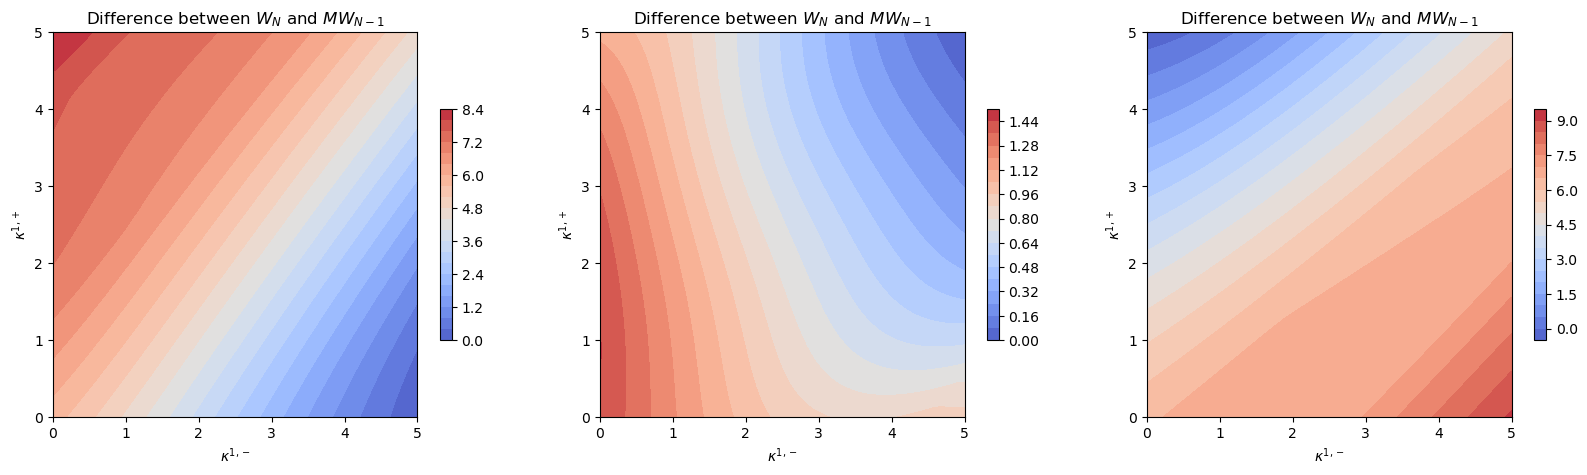

In [101]:
# Define grid for pi and kappa (filter probability and liquidity parameter)

kappa_plus_values = np.linspace(0, 5, 50)  # Filter probability grid
kappa_minus_values = np.linspace(0, 5, 50)  # Liquidity parameter grid

# Placeholder for value function V(pi, kappa) and intervention operator MV(pi, kappa)
V_0 = np.zeros((len(kappa_plus_values), len(kappa_minus_values)))
V_1 = np.zeros((len(kappa_plus_values), len(kappa_minus_values)))
V_2 = np.zeros((len(kappa_plus_values), len(kappa_minus_values)))
MV_0 = np.zeros_like(V_0)
MV_1 = np.zeros_like(V_0)
MV_2 = np.zeros_like(V_0)
MV_size_0 = np.zeros_like(V_0)
MV_size_1 = np.zeros_like(V_0)
MV_size_2 = np.zeros_like(V_0)

difference_0 = np.zeros_like(V_0)
difference_1 = np.zeros_like(V_0)
difference_2 = np.zeros_like(V_0)

# Tolerance for floating-point comparison
tolerance = 9

# Calculate V and MV for each point in the grid
for i, kappa_minus in enumerate(kappa_minus_values):
    for j, kappa_plus in enumerate(kappa_plus_values):  
        kappa_0 = np.array([[kappa_plus, kappa_minus], [kappa_minus, kappa_plus]])  # Liquidity parameter matrix
        mu_0 = np.array([0.1, 0.9])
        mu_1 = np.array([0.5, 0.5])
        mu_2 = np.array([0.9, 0.1])
        y_0 = (x, d, kappa_0, mu_0)  # State variables (including pi and kappa)
        y_1 = (x, d, kappa_0, mu_1)  # State variables (including pi and kappa)
        y_2 = (x, d, kappa_0, mu_2)  # State variables (including pi and kappa)
        V_0[i, j] = W_N(t, y_0)  # Compute the value function
        V_1[i, j] = W_N(t, y_1)  # Compute the value function
        V_2[i, j] = W_N(t, y_2)  # Compute the value function
        MV_0[i, j], MV_size_0[i, j] = res2.M_value_function(t, W_N, y_0)  # Compute the intervention value
        MV_1[i, j], MV_size_1[i, j] = res2.M_value_function(t, W_N, y_1)  # Compute the intervention value
        MV_2[i, j], MV_size_2[i, j] = res2.M_value_function(t, W_N, y_2)  # Compute the intervention value
        difference_0[i, j] = V_0[i, j]-MV_0[i, j]
        difference_1[i, j] = V_1[i, j]-MV_1[i, j]
        difference_2[i, j] = V_2[i, j]-MV_2[i, j]

# Plot the figures
fig = plt.figure(figsize=(20, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1], wspace=0.2)

# Plot 1: Difference between V and MV
ax1 = fig.add_subplot(gs[2])
contour1 = ax1.contourf(kappa_minus_values, kappa_plus_values, difference_0.T, levels=20, cmap=cmap)
cbar1 = fig.colorbar(contour1, ax=ax1, shrink=0.6)
ax1.set_title('Difference between $W_N$ and $MW_{N-1}$')
ax1.set_xlabel('$\kappa^{1,-}$')
ax1.set_ylabel('$\kappa^{1,+}$')

# Plot 2: Difference between V and MV
ax2 = fig.add_subplot(gs[1])
contour2 = ax2.contourf(kappa_minus_values, kappa_plus_values, difference_1.T, levels=20, cmap=cmap)
cbar2 = fig.colorbar(contour2, ax=ax2, shrink=0.6)
ax2.set_title('Difference between $W_N$ and $MW_{N-1}$')
ax2.set_xlabel('$\kappa^{1,-}$')
ax2.set_ylabel('$\kappa^{1,+}$')

# Plot 3: Difference between V and MV
ax3 = fig.add_subplot(gs[0])
contour3 = ax3.contourf(kappa_minus_values, kappa_plus_values, difference_2.T, levels=20, cmap=cmap)
cbar3 = fig.colorbar(contour3, ax=ax3, shrink=0.6)
ax3.set_title('Difference between $W_N$ and $MW_{N-1}$')
ax3.set_xlabel('$\kappa^{1,-}$')
ax3.set_ylabel('$\kappa^{1,+}$')

plt.tight_layout()
plt.savefig('exercice_region_intensities_{}_switch.pdf'.format(N), bbox_inches='tight', pad_inches=0)
plt.show()


## Inventory vs Filter

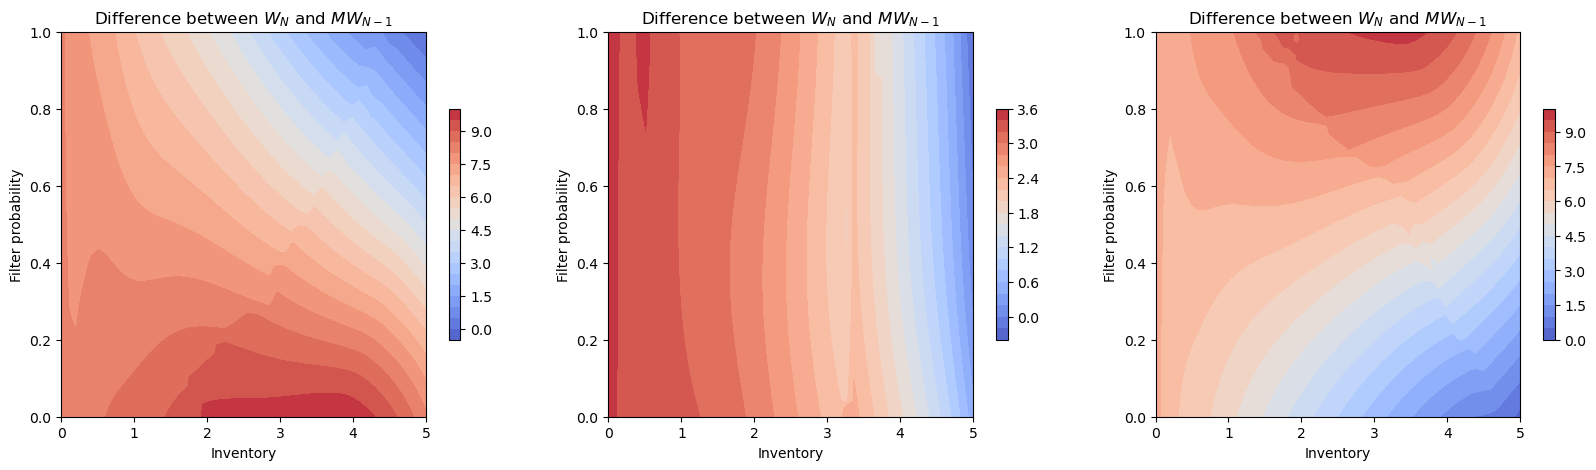

In [108]:
# Define grid for pi and kappa (filter probability and liquidity parameter)
d=5
X_values = np.linspace(0, 5, 50)  # Filter probability grid
pi_values = np.linspace(0, 1, 50)  # Liquidity parameter grid

# Placeholder for value function V(pi, kappa) and intervention operator MV(pi, kappa)
V_0 = np.zeros((len(X_values), len(X_values)))
V_1 = np.zeros((len(X_values), len(X_values)))
V_2 = np.zeros((len(X_values), len(X_values)))
MV_0 = np.zeros_like(V_0)
MV_1 = np.zeros_like(V_0)
MV_2 = np.zeros_like(V_0)
MV_size_0 = np.zeros_like(V_0)
MV_size_1 = np.zeros_like(V_0)
MV_size_2 = np.zeros_like(V_0)

difference_0 = np.zeros_like(V_0)
difference_1 = np.zeros_like(V_0)
difference_2 = np.zeros_like(V_0)

# Tolerance for floating-point comparison
tolerance = 9

# Calculate V and MV for each point in the grid
for i, v in enumerate(X_values):
    for j, pi in enumerate(pi_values):
        kappa_0 = np.array([[lambda_init_0,lambda_init_1], [lambda_init_1 , lambda_init_0]])
        kappa_1 = np.array([[lambda_init_2,lambda_init_2], [lambda_init_2 , lambda_init_2]])
        kappa_2 = np.array([[lambda_init_1,lambda_init_0], [lambda_init_0 , lambda_init_1]])
        mu_0 = np.array([pi, 1-pi])
        y_0 = (v, d, kappa_0, mu_0)  # State variables (including pi and kappa)
        y_1 = (v, d, kappa_1, mu_0)  # State variables (including pi and kappa)
        y_2 = (v, d, kappa_2, mu_0)  # State variables (including pi and kappa)
        V_0[i, j] = W_N(t, y_0)  # Compute the value function
        V_1[i, j] = W_N(t, y_1)  # Compute the value function
        V_2[i, j] = W_N(t, y_2)  # Compute the value function
        MV_0[i, j], MV_size_0[i, j] = res2.M_value_function(t, W_N, y_0)  # Compute the intervention value
        MV_1[i, j], MV_size_1[i, j] = res2.M_value_function(t, W_N, y_1)  # Compute the intervention value
        MV_2[i, j], MV_size_2[i, j] = res2.M_value_function(t, W_N, y_2)  # Compute the intervention value
        difference_0[i, j] = V_0[i, j]-MV_0[i, j]
        difference_1[i, j] = V_1[i, j]-MV_1[i, j]
        difference_2[i, j] = V_2[i, j]-MV_2[i, j]

# Plot the figures
# Plot the figures with adjusted size and spacing
fig = plt.figure(figsize=(20,5))  # Reduced figure size
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1], wspace=0.2)  # Increased space between subplots

# Plot 1: Difference between V and MV
ax4 = fig.add_subplot(gs[2])
contour4 = ax4.contourf(X_values, pi_values, difference_0.T, levels=20, cmap=cmap)
cbar4 = fig.colorbar(contour4, ax=ax4, shrink=0.6)  # Increased colorbar size
ax4.set_title('Difference between $W_N$ and $MW_{N-1}$')
ax4.set_xlabel('Inventory')
ax4.set_ylabel('Filter probability')

# Plot 2: Difference between V and MV
ax5 = fig.add_subplot(gs[1])
contour5 = ax5.contourf(X_values, pi_values, difference_1.T, levels=20, cmap=cmap)
cbar5 = fig.colorbar(contour5, ax=ax5, shrink=0.6)  # Increased colorbar size
ax5.set_title('Difference between $W_N$ and $MW_{N-1}$')
ax5.set_xlabel('Inventory')
ax5.set_ylabel('Filter probability')

# Plot 3: Difference between V and MV
ax6 = fig.add_subplot(gs[0])
contour6 = ax6.contourf(X_values, pi_values, difference_2.T, levels=20, cmap=cmap)
cbar6 = fig.colorbar(contour6, ax=ax6, shrink=0.6)  # Increased colorbar size
ax6.set_title('Difference between $W_N$ and $MW_{N-1}$')
ax6.set_xlabel('Inventory')
ax6.set_ylabel('Filter probability')

# Save and show the plot
plt.savefig('exercice_region_filter_inventory_{}_switch.pdf'.format(N), bbox_inches='tight', pad_inches=0)
plt.show()
